<a href="https://colab.research.google.com/github/zergswim/study/blob/main/2%EC%A1%B0_5%EC%A3%BC%EC%B0%A8_%EB%AF%B8%EC%85%98_%EC%A0%9C%EB%A6%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Q1.
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms

from torch.utils.data import DataLoader

#MNIST 데이터 다운로드
root = './data'
mnist_train = dset.MNIST(root=root, train=True, transform=transforms.ToTensor(), download=True) 
mnist_test = dset.MNIST(root=root, train=False, transform=transforms.ToTensor(), download=True)

#데이터 로더 정의
batch_size = 100
train_loader = DataLoader(mnist_train, batch_size = batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size = batch_size, shuffle=False, drop_last=True)

# for X, y in test_loader:
#     print("Shape of X [N, C, H, W]: ", X.shape)
#     print("Shape of y: ", y.shape, y.dtype)
#     break

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
#Q2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #GPU 사용여부체크
# linear = nn.Linear(784, 10, bias=True).to(device) #단순 선형레이어 정의
# torch.nn.init.normal_(linear.weight) #레이어 초기화

#nn.Module 상속, 커스텀 모델 정의
class CustomModel(nn.Module): 
    def __init__(self):
        super(CustomModel, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512), #이미지 크기 28px*28px = 784
            nn.ReLU(), #비선형처리(ReLU)
            nn.Linear(512, 512), #중간레이어 지정
            nn.ReLU(), #비선형처리(ReLU)
            nn.Linear(512, 10) #결과값 0~9까지 = 10
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = CustomModel().to(device)


In [ ]:
#Q3
criterion = nn.CrossEntropyLoss().to(device) # lost function 정의
optimizer = torch.optim.SGD(model.parameters(), lr=0.1) # SGD 방식, learning rate 지정

In [ ]:
#Q4
training_epochs = 5
for epoch in range(training_epochs):
    for i, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        imgs = imgs.view(-1, 28*28)

        #모델에 이미지내용 입력
        #outputs = linear(imgs)
        outputs = model(imgs)

        #정답(labels)과의 error 계산
        loss = criterion(outputs, labels) 

        optimizer.zero_grad()
        loss.backward()    # gradients 계산(backpropagation)
        optimizer.step()   # gradients 업데이트

        _,pred = torch.max(outputs, 1) # 최대 출력값(예측)
        accuracy = (labels == pred).float().mean() #labels 와 비교해서 정확도 계산

        if (i+1) % 100 == 0:
          print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%"
          .format(epoch+1, training_epochs, i+1, len(train_loader), loss.item(), accuracy.item() * 100))

Epoch [1/5], Step [100/600], Loss: 0.7582, Accuracy: 76.00%
Epoch [1/5], Step [200/600], Loss: 0.4994, Accuracy: 84.00%
Epoch [1/5], Step [300/600], Loss: 0.4027, Accuracy: 89.00%
Epoch [1/5], Step [400/600], Loss: 0.3664, Accuracy: 90.00%
Epoch [1/5], Step [500/600], Loss: 0.2994, Accuracy: 91.00%
Epoch [1/5], Step [600/600], Loss: 0.3441, Accuracy: 90.00%
Epoch [2/5], Step [100/600], Loss: 0.1730, Accuracy: 95.00%
Epoch [2/5], Step [200/600], Loss: 0.2737, Accuracy: 93.00%
Epoch [2/5], Step [300/600], Loss: 0.1586, Accuracy: 95.00%
Epoch [2/5], Step [400/600], Loss: 0.2308, Accuracy: 91.00%
Epoch [2/5], Step [500/600], Loss: 0.1495, Accuracy: 96.00%
Epoch [2/5], Step [600/600], Loss: 0.2479, Accuracy: 93.00%
Epoch [3/5], Step [100/600], Loss: 0.0706, Accuracy: 99.00%
Epoch [3/5], Step [200/600], Loss: 0.2047, Accuracy: 96.00%
Epoch [3/5], Step [300/600], Loss: 0.3279, Accuracy: 94.00%
Epoch [3/5], Step [400/600], Loss: 0.1541, Accuracy: 95.00%
Epoch [3/5], Step [500/600], Loss: 0.112

In [ ]:
#Q5
model.eval()
# linear.eval()

with torch.no_grad():
  correct = 0
  total = 0
  for i, (imgs, labels) in enumerate(test_loader):
    imgs, labels = imgs.to(device), labels.to(device)
    imgs = imgs.view(-1, 28*28)

#   outputs = linear(imgs)
    outputs = model(imgs)

    pred = outputs.data.max(1)[1] # 최대 출력값(예측)
    #_,argmax = torch.max(outputs, 1)

    total += imgs.size(0)
    correct += (labels == pred).sum().item()

  print("Test accuracy for {} images : {:.2f}%".format(total, correct/total*100))

Test accuracy for 10000 images : 96.85%


Label:  3
Prediction:  3


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


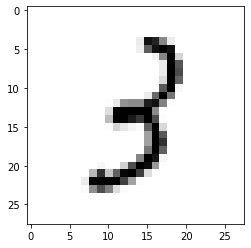

In [ ]:
#MNIST 샘플데이터 테스트
import matplotlib.pyplot as plt
import random

r = random.randint(0, len(mnist_test) - 1)
X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28*28).float().to(device)
Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

print("Label: ", Y_single_data.item())
single_prediction = model(X_single_data)
#single_prediction = linear(X_single_data)
print("Prediction: ", torch.argmax(single_prediction,1).item())
plt.imshow(mnist_test.test_data[r:r + 1].view(28, 28),cmap="Greys", interpolation="nearest")
plt.show()

In [ ]:
#bool 연산 속도 테스트
import pandas as pd
import random

r = random.sample(range(1, 100000), 10000)
s = pd.Series(r)
#print(s)
f = lambda x : x>10 and x < 100
%timeit s[s.apply(f)]
%timeit s[s > 10][s < 100]
%timeit s[(s > 10) & (s < 100)]


100 loops, best of 5: 2.77 ms per loop
The slowest run took 8.30 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 5: 1.16 ms per loop
1000 loops, best of 5: 520 µs per loop
